### Construindo a NAIRU - Non Accelerating Inflation Rate of Unemployment

**É, de maneira sucinta, a taxa de desemprego em que a inflação permanece estável. Essa relação entre desemprego e inflação é capturada pela curva de Phillips.**

O procedimento para obter a NAIRU:

1. Estimar uma Curva de Phillips
2. A partir dos parâmetros estimados, obter a NAIRU 
3. Obter o componente cíclico (NAIRU) da soma em 2 através do filtro HP

A fórmula de cálculo da NAIRU pode ser representada como:

$$
\pi = \pi^e + a(U - U^*) + v
$$

Onde:
- $U$ é a taxa de desemprego observada
- $U^*$ é a taxa de desemprego natural
- $\pi$ é a inflação corrente
- $\pi^e$ é a inflação esperada (com expectativas racionais)
- $v$ representa um choque de oferta

Para obter $U*$, rearranjamos a equação para: 

$$
U^* + v/a = U + \Delta \pi / a
$$



O lado direito pode ser obtido somente com os dados, e com a estimação de $a$ através da curva de phillips. O resultado será a estimativa da NAIRU ($U*$) somado com os choques de curto prazo ($v/a$). Assim, para obter o componente cíclico (NAIRU) aplicamos o Filtro HP



#### 1. Carregando bibliotecas

In [1]:
import pandas as pd
import numpy as np
from bcb import sgs
from bcb import Expectativas
from plotnine import *
import statsmodels.api as sm
from statsmodels.tsa import x13
import os 

c:\Users\Jose.Alfaix\.conda\envs\riobravo_env1\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


#### 2.1 Extraindo desocupação e realizando o ajuste sazonal via X-13 Arima Seats

In [2]:
pnad = sgs.get({'pnad' : 24369})

import urllib.request
import zipfile

url = "https://www2.census.gov/software/x-13arima-seats/x13as/windows/program-archives/x13as_ascii-v1-1-b59.zip"
nome_arquivo_zip = "x13as_ascii-v1-1-b59.zip"

# Baixa o arquivo
urllib.request.urlretrieve(url, nome_arquivo_zip)

# Extrai o arquivo zipado
with zipfile.ZipFile(nome_arquivo_zip, 'r') as zip_ref:
    zip_ref.extractall()
    
# Define o caminho do programa como variável de ambiente
os.environ["X13PATH"] = "x13as"

# Ajusta sazonalmente a pnad
pnad_sa = (
    pnad
    .assign(pnad_sa = lambda x: x13.x13_arima_analysis(endog = x.pnad).seasadj)
    .reset_index()
)

pnad_sa

c:\Users\Jose.Alfaix\.conda\envs\riobravo_env1\lib\site-packages\statsmodels\tsa\x13.py:203: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.


,Date,pnad,pnad_sa
0,2012-03-01,8.0,7.472867
1,2012-04-01,7.8,7.410211
2,2012-05-01,7.7,7.406124
3,2012-06-01,7.6,7.442561
4,2012-07-01,7.5,7.346231
...,...,...,...
145,2024-04-01,7.5,7.204788
146,2024-05-01,7.1,6.982189
147,2024-06-01,6.9,6.942949
148,2024-07-01,6.8,6.843652


##### 2.2 Extraindo expectativas de inflação

In [3]:
# Instância a classe de expectativas
em = Expectativas()

# Obtém o endpoint da Expectativa de Inflação Acumulada em 12 meses
exp_ipca_raw = em.get_endpoint('ExpectativasMercadoInflacao12Meses')

# Realiza a importação da Expectativa de Inflação Acumulada em 12 meses
exp_ipca = (
  exp_ipca_raw.query() # faz a consulta
 .filter(exp_ipca_raw.Indicador == 'IPCA') # filtra apenas para o IPCA
 .filter(exp_ipca_raw.baseCalculo == '0') # filtra a Base de Cálculo para 0
 .filter(exp_ipca_raw.Suavizada == 'S') # filtra Suavizada para S
 .collect() # faz a importação dos dados
  [['Data', 'Mediana']]
  )

# Tratamento da expectativa de inflação em 12 meses
## Mensaliza expectativa (média)
exp_ipca_aux = (
  exp_ipca
 .assign(Year = lambda x: pd.to_datetime(x.Data).dt.year,
         Month = lambda x: pd.to_datetime(x.Data).dt.month)
  .groupby(by = ['Year', 'Month'])
  .agg({'Mediana' : 'mean'})
  .reset_index()
  .assign(Date = lambda x: pd.to_datetime(x[['Year', 'Month']].assign(Day = 1)))
 [['Date', 'Mediana']]
)

exp_ipca_aux

,Date,Mediana
0,2001-12-01,5.030000
1,2002-01-01,4.733636
2,2002-02-01,4.644737
3,2002-03-01,4.721500
4,2002-04-01,4.790000
...,...,...
270,2024-06-01,3.597295
271,2024-07-01,3.670978
272,2024-08-01,3.772632
273,2024-09-01,3.980814


##### 2.3 Extraindo inflação corrente

In [5]:
# Importa IPCA mensal
df = sgs.get({'ipca': 433}, start='2011-01-01')

# Calcula a variação acumulada em 12 meses do IPCA
ipca_12m = df.rolling(12).apply(lambda x: (1 + x/100).prod() - 1).dropna() * 100
ipca_12m.reset_index(inplace = True)

##### 2.4 Estimando a NAIRU

In [6]:
# Junta os dataframe
dados_ipca = (
              pd.merge(ipca_12m, exp_ipca_aux,  how = 'inner', on = 'Date')
              .sort_values('Date')
)

# Cria diferença entre ipca corrente e expectativa
dados_ipca['delta_ipca_exp'] = dados_ipca.ipca - dados_ipca.Mediana

# Junta os dados
dados = (pd.merge(dados_ipca, pnad_sa,  how = 'inner', on = 'Date')
              .sort_values('Date')
              .set_index('Date')
          )

# Diferencia desemprego t/t-12
dados['pnad_diff12'] = dados.pnad.diff(12)

# Ajustar o modelo de regressão usando from_formula
cp = sm.OLS.from_formula('delta_ipca_exp ~ pnad_diff12', data=dados).fit()
print(cp.summary())

                            OLS Regression Results                            
Dep. Variable:         delta_ipca_exp   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.083
Date:                Mon, 07 Oct 2024   Prob (F-statistic):             0.0814
Time:                        12:17:08   Log-Likelihood:                -290.10
No. Observations:                 138   AIC:                             584.2
Df Residuals:                     136   BIC:                             590.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.1385      0.170      6.705      

In [7]:
# Cria as mudanças na curva de phillips
shifts_cp = dados.pnad_sa + (dados.delta_ipca_exp / cp.params['Intercept'])

# Calcula o filtro HP
filtro_cp = sm.tsa.filters.hpfilter(x = shifts_cp, lamb = 129600)

# Salva a tendência calculada
dados['nairu'] = filtro_cp[1] # posição 1 é a tendência (0=ciclo);
dados

,ipca,Mediana,delta_ipca_exp,pnad,pnad_sa,pnad_diff12,nairu
Date,,,,,,,
2012-03-01,5.239993,5.375000,-0.135007,8.0,7.472867,NaN,6.253346
2012-04-01,5.104226,5.473000,-0.368774,7.8,7.410211,NaN,6.352272
2012-05-01,4.989152,5.520909,-0.531757,7.7,7.406124,NaN,6.451207
2012-06-01,4.915770,5.493000,-0.577230,7.6,7.442561,NaN,6.550164
2012-07-01,5.198590,5.542727,-0.344137,7.5,7.346231,NaN,6.649162
...,...,...,...,...,...,...,...
2024-04-01,3.688016,3.530673,0.157344,7.5,7.204788,-1.0,8.734808
2024-05-01,3.925952,3.614862,0.311090,7.1,6.982189,-1.2,8.576827
2024-06-01,4.227578,3.597295,0.630283,6.9,6.942949,-1.1,8.418806


In [8]:
# Cria o gráfico
dados_long = (
            dados
            .rename(columns = {'nairu' : 'NAIRU',
                              'pnad_sa' : 'Taxa de Desocupação S.A.'})
            .reset_index()
            [['Date', 'Taxa de Desocupação S.A.', 'NAIRU']]
            .melt(id_vars = ['Date'])
          )
dados_long

,Date,variable,value
0,2012-03-01,Taxa de Desocupação S.A.,7.472867
1,2012-04-01,Taxa de Desocupação S.A.,7.410211
2,2012-05-01,Taxa de Desocupação S.A.,7.406124
3,2012-06-01,Taxa de Desocupação S.A.,7.442561
4,2012-07-01,Taxa de Desocupação S.A.,7.346231
...,...,...,...
295,2024-04-01,NAIRU,8.734808
296,2024-05-01,NAIRU,8.576827
297,2024-06-01,NAIRU,8.418806
298,2024-07-01,NAIRU,8.260763


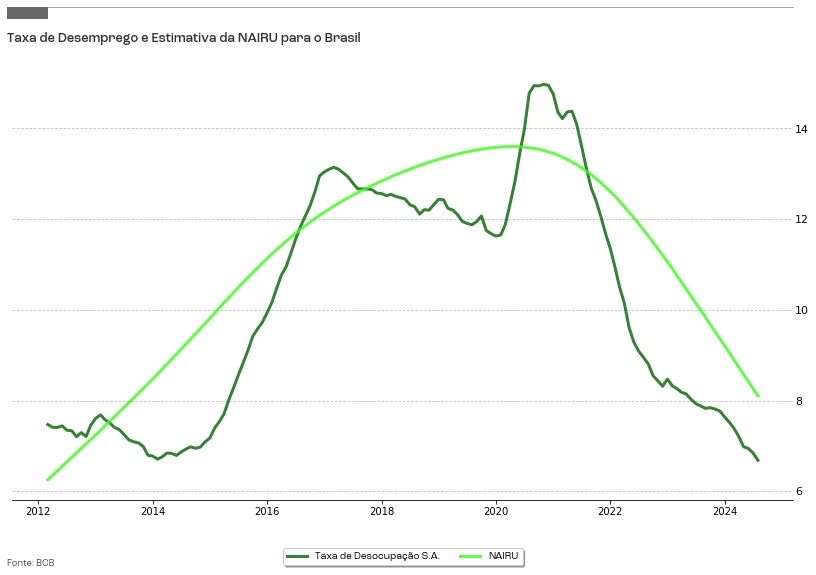

In [10]:
variables = dados_long["variable"].unique()
variables

import matplotlib.pyplot as plt
import numpy as np

# Setup plot size.
fig, ax = plt.subplots(figsize=(14, 8))
plt.rcParams['font.family'] = 'Roc Grotesk' 


cores = ['#006400','#39FF14'] 

for i, variable in enumerate(variables):
        color = cores[i % len(cores)]  
        ax.plot(dados_long[dados_long['variable'] == variable]['Date'],
            dados_long[dados_long['variable'] == variable]['value'],
            color=color,
            alpha=0.8,
            linewidth=3,
            label=variable)  

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=len(variables))

######### Estética do Gráfico #########

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)  # Add grid lines for y-axis

ax.yaxis.set_tick_params(pad=-2, labeltop=True, labelbottom=False, bottom=False, labelsize=11)

# Adiciona linha e tag
ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#696969', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12, .98), 0.04, -0.02, facecolor='#696969', transform=fig.transFigure, clip_on=False, linewidth=0))

# Adiciona título e subtítulo
ax.text(x=0.12, y=.92, s="Taxa de Desemprego e Estimativa da NAIRU para o Brasil", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
# Adiciona a fonte
ax.text(x=0.12, y=0.01, s="""Fonte: BCB""", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

plt.show()


In [11]:
# Cria hiato do desemprego
dados['hiato_pnad'] = dados.pnad_sa.values - dados.nairu.values

# Cria o gráfico
dados_hiato_long = (
            dados
            .rename(columns = {'ipca' : 'IPCA acumulado em 12 meses',
                              'hiato_pnad' : 'Taxa de Desocupação - NAIRU'})
            .reset_index()
            [['Date', 'Taxa de Desocupação - NAIRU', 'IPCA acumulado em 12 meses']]
            .melt(id_vars = ['Date'])
          )
dados_hiato_long

,Date,variable,value
0,2012-03-01,Taxa de Desocupação - NAIRU,1.219521
1,2012-04-01,Taxa de Desocupação - NAIRU,1.057938
2,2012-05-01,Taxa de Desocupação - NAIRU,0.954917
3,2012-06-01,Taxa de Desocupação - NAIRU,0.892397
4,2012-07-01,Taxa de Desocupação - NAIRU,0.697069
...,...,...,...
295,2024-04-01,IPCA acumulado em 12 meses,3.688016
296,2024-05-01,IPCA acumulado em 12 meses,3.925952
297,2024-06-01,IPCA acumulado em 12 meses,4.227578
298,2024-07-01,IPCA acumulado em 12 meses,4.498245


In [12]:
variables_2 = dados_hiato_long["variable"].unique()
variables_2

array(['Taxa de Desocupação - NAIRU', 'IPCA acumulado em 12 meses'],
      dtype=object)

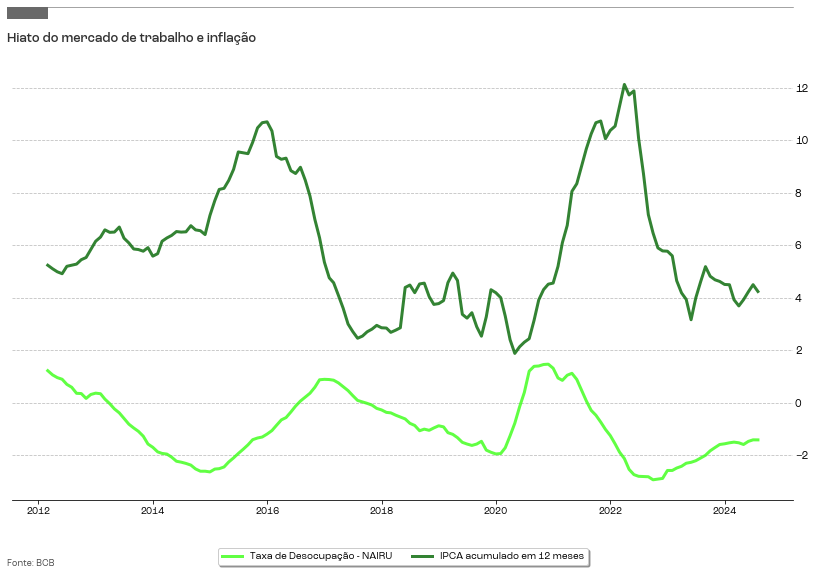

In [14]:
fig, ax = plt.subplots(figsize=(14, 8))

 # Escolhe a cor com base no índice
cores = ['#39FF14', '#006400']  # Verde fluorescente e verde escuro

# Supondo que 'variables_2' é a lista de variáveis que você deseja plotar
for i, variable in enumerate(variables_2):
    # Se você tiver mais variáveis do que cores, adicione mais cores à lista acima
    color = cores[i % len(cores)]  # Escolhe a cor com base no índice
    ax.plot(dados_hiato_long[dados_hiato_long['variable'] == variable]['Date'],
            dados_hiato_long[dados_hiato_long['variable'] == variable]['value'],
            color=color,
            alpha=0.8,
            linewidth=3,
            label=variable)  # Adiciona rótulo para a legenda

# Adiciona a legenda abaixo do gráfico.
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=len(variables_2))

######### Estética do Gráfico #########

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)  # Add grid lines for y-axis

ax.yaxis.set_tick_params(pad=-2, labeltop=True, labelbottom=False, bottom=False, labelsize=11)

# Adiciona linha e tag
ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#696969', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12, .98), 0.04, -0.02, facecolor='#696969', transform=fig.transFigure, clip_on=False, linewidth=0))

# Adiciona título e subtitulo
ax.text(x=0.12, y=.92, s="Hiato do mercado de trabalho e inflação", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
# Adiciona fonte
ax.text(x=0.12, y=0.01, s="""Fonte: BCB""", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

plt.show()
